In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette(['#376CA8', '#25A37B', '#E44574', '#796E9C'])

sns.set_context('paper')

# Note that these are not my standard settings
sns.set_style({
   'axes.axisbelow': True, 
   'axes.edgecolor': '.15', 
   'axes.facecolor': 'white',
   'axes.grid': True, 
   'axes.labelcolor': '.15',
   'axes.labelsize': 5,
   'axes.linewidth': 0.5, 
   'axes.spines.right': False, 
   'axes.spines.top': False,  
   'axes.titlesize': 5,
   'figure.facecolor': 'white', 
   'font.family': ['sans-serif'], 
   'grid.color': '.15',
   'grid.linestyle': ':', 
   'grid.linewidth': 0.1,
   'grid.alpha': .5, 
   'image.cmap': 'Greys', 
   'legend.frameon': False, 
   'legend.fontsize': 5,
   'legend.numpoints': 1, 
   'legend.scatterpoints': 1,
   'lines.solid_capstyle': 'round', 
   
   'text.color': '.15',  
   'xtick.top': False, 
   'ytick.right': False, 
})

for tick in ['xtick', 'ytick']:
    sns.set_style({
        f'{tick}.color': '.15',
        f'{tick}.direction': 'out', 
        f'{tick}.labelsize': 5,
        
        f'{tick}.major.pad': 2,
        f'{tick}.major.size': 2, 
        f'{tick}.major.width': 0.5,
        
        f'{tick}.minor.size': 1.5,
        f'{tick}.minor.width': 0.2,
        f'{tick}.minor.pad': 2,
        
    })
    
#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
DPI = 500

In [3]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [4]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE
with pd.HDFStore(PTM_RESPONSE_FILE, 'r') as store:
    
    enrichment_complexes = store['ptm_stats/joint_camera_complexes']

In [5]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import *

In [6]:
import palettable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [7]:
x = 'H3ac'
y = 'H4ac'

logfc_threshold = 0.75
# logfc_threshold = 0.5
complexes_to_keep = set(enrichment_complexes.reset_index()['Complex'].unique())
value_column = 'empirical_median'
value_ci_low_column = 'empirical_median_ci_left'
value_ci_high_column = 'empirical_median_ci_right'

data = enrichment_complexes.loc[[x,y]].unstack('predictor')

mask = data['significant'].any(axis=1)
mask &= (data[value_column].abs() >= logfc_threshold).any(axis=1)
mask &= (~data[value_column].isnull()).all(axis=1)

data = data[mask]

diff = data[value_column][x] - data[value_column][y]
diff = diff.sort_values(ascending=False)

order = diff.index

data = data.loc[order]

data[value_column]

predictor,H4ac,H3ac
Complex,,
PBAF,0.585453,4.685299
BAF,0.750033,4.442430
EBAFA/B,0.669104,4.019548
GBAF,1.119189,2.904615
ATAC (exclusive subunits),0.174213,1.225198
MLL3/4 (exclusive subunits),0.485690,1.469931
ATAC,0.183243,1.140309
MLL3/4,0.348293,1.192965
NuRF,0.273590,0.943684


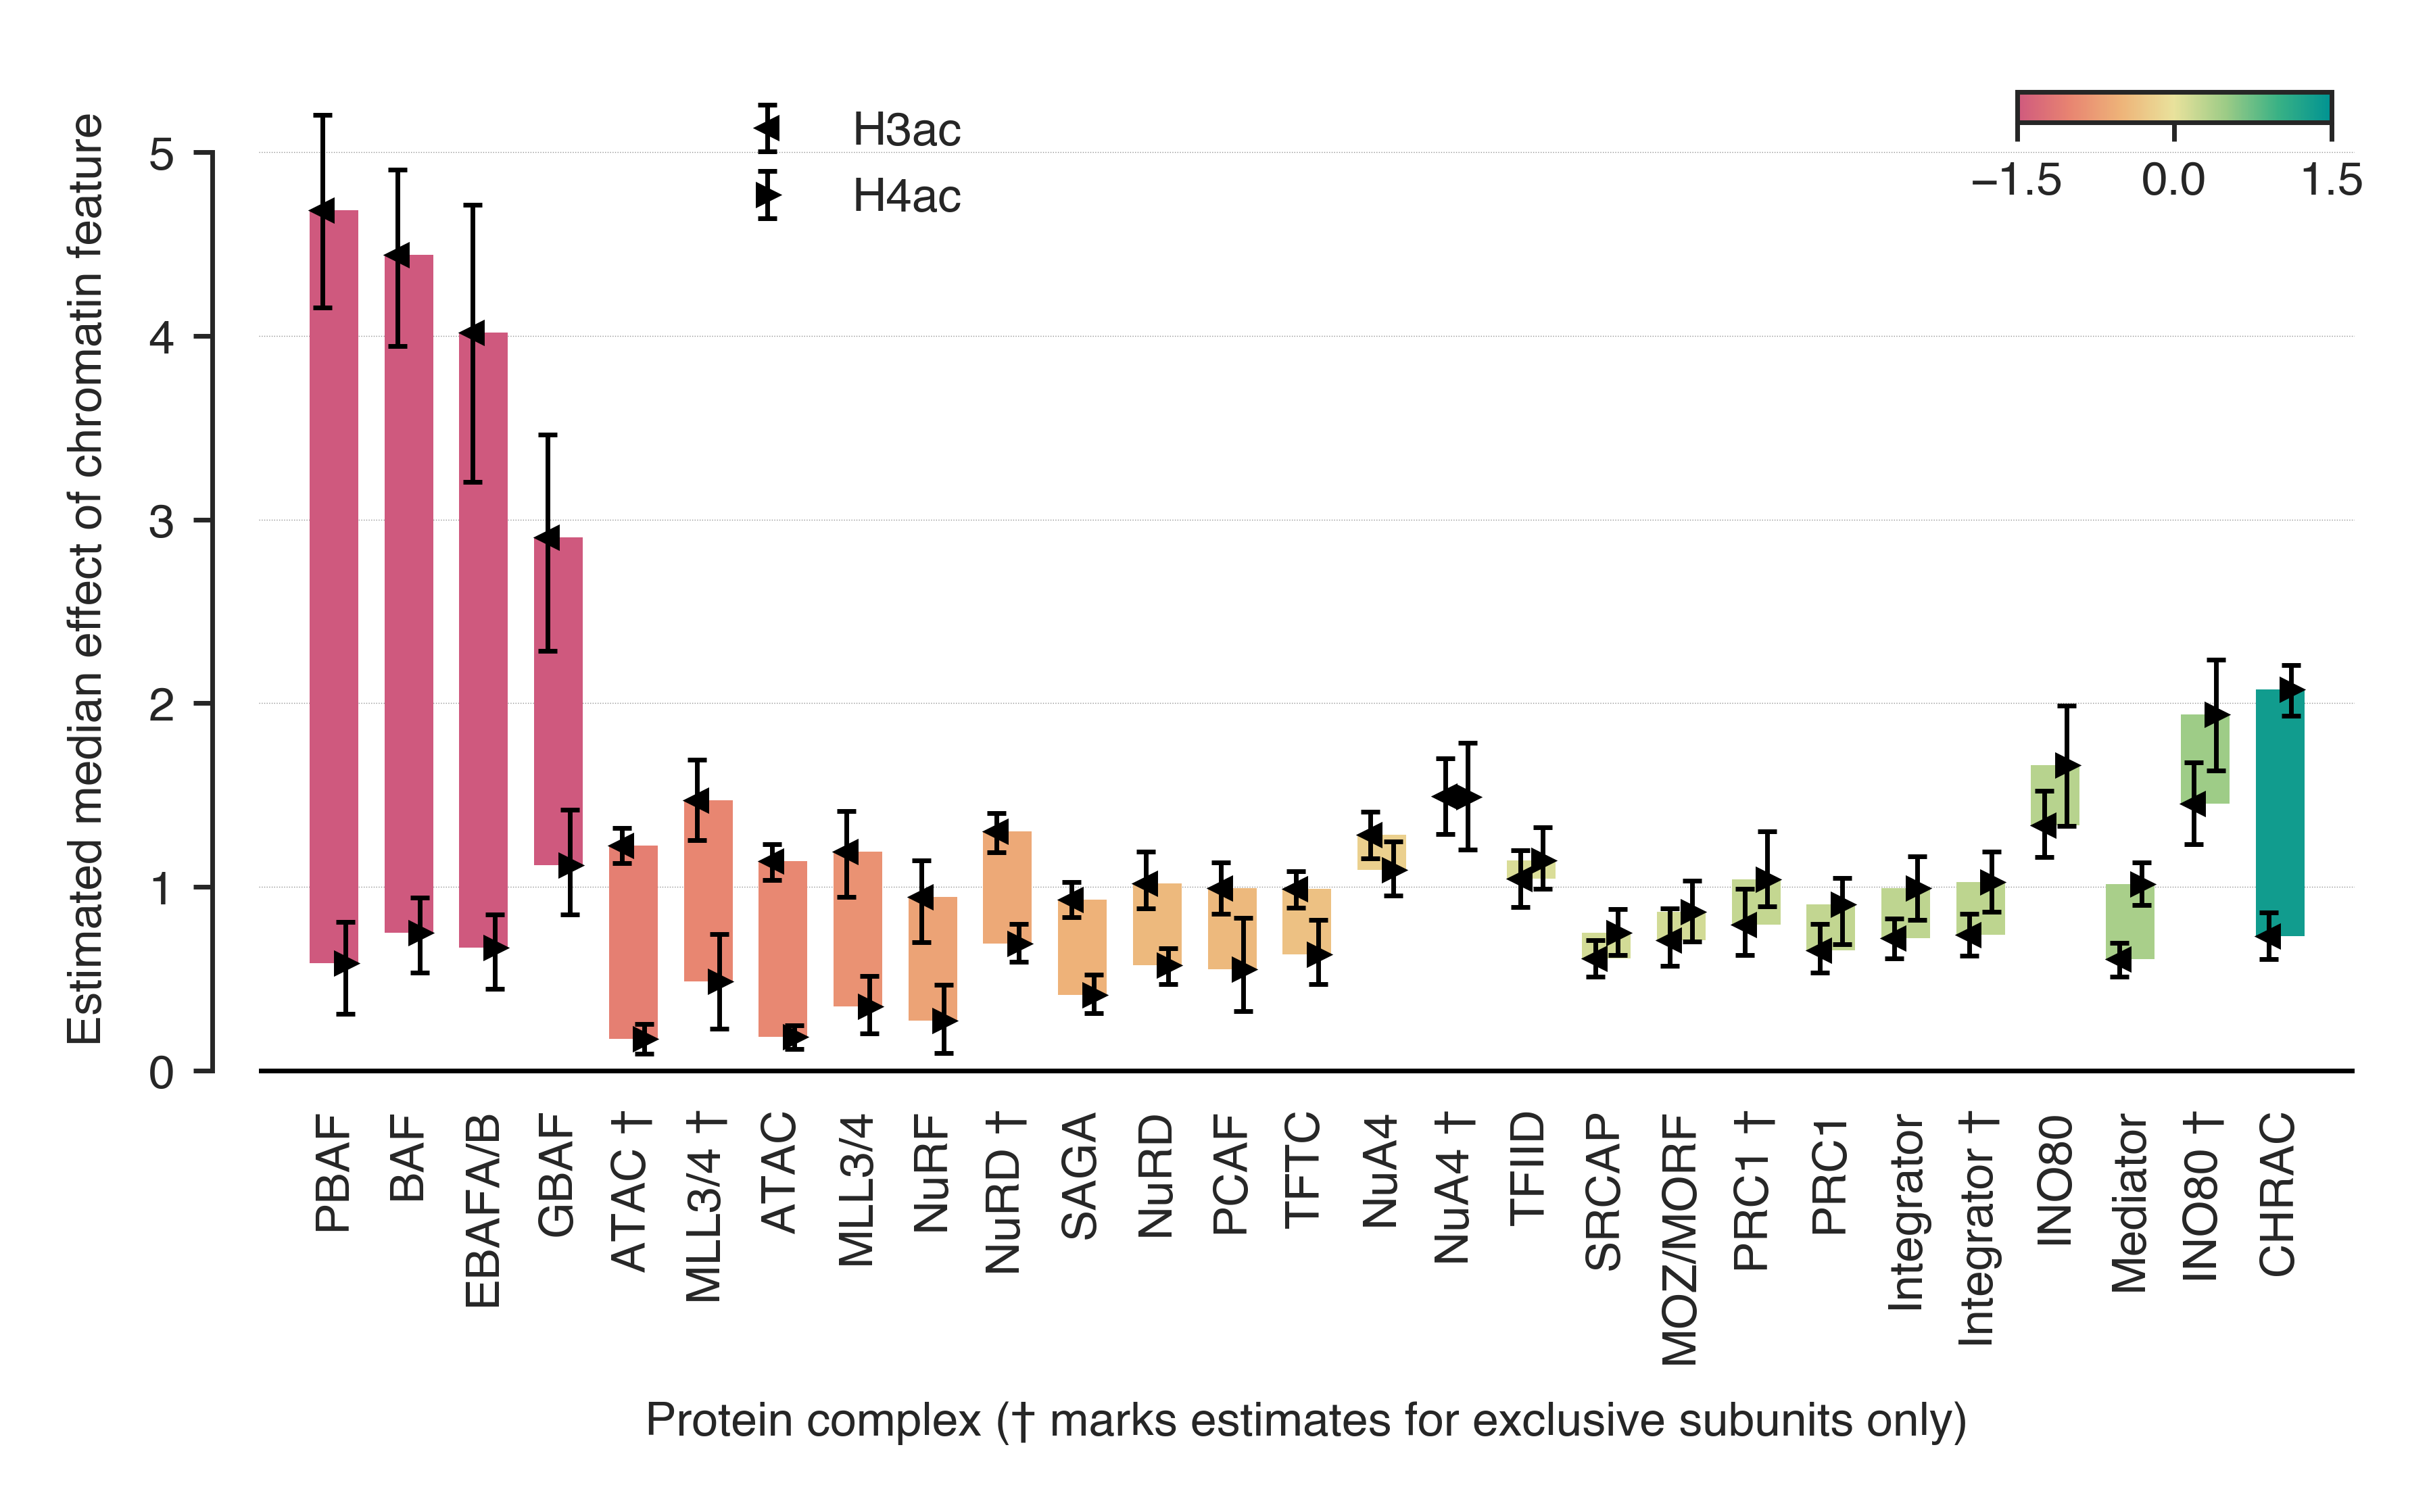

In [8]:
fig = plt.figure(figsize=(4, 2), dpi=DPI)
ax = plt.gca()

ax_cbar = inset_axes(ax,
                     width="15%",
                     height="3%",
                     loc='upper right')

x_coordinates = np.arange(len(order))
rect_width = 0.65
x_offset = 0.15

palette = palettable.cartocolors.diverging.Temps_7_r

color_x = 'black'
color_y = 'black'

marker_x = '<'
marker_y = '>'

cmap = palette.mpl_colormap
cmap_norm = Normalize(-1.5, 1.5)

ordered_data = data.loc[order]

kwargs_medians = dict(
    markersize=2,
    markeredgewidth=0.5,
    linestyle='none',
    elinewidth=0.5,
    markeredgecolor='black',
    capsize=1,
)


for ptm, offset, colour, marker in zip([x, y], [-x_offset, +x_offset], [color_x, color_y], [marker_x, marker_y]):
    values = ordered_data[(value_column, ptm)]
    values_ci_low = ordered_data[(value_ci_low_column, ptm)]
    values_ci_high = ordered_data[(value_ci_high_column, ptm)]
    
    err_low = values - values_ci_low
    err_high = values_ci_high - values
    

    # Median lines
    ax.errorbar(x_coordinates + offset,
                values,
                yerr=np.vstack((err_low, err_high)),
                label=ptm,
                color=colour,
                marker=marker,
                **kwargs_medians)

rects = []

label_colors = {}


for x_coord, complex_ in enumerate(order):
    
    value_ptm_x = ordered_data.loc[complex_, (value_column, x)]
    value_ptm_y = ordered_data.loc[complex_, (value_column, y)]
    
    value_diff = value_ptm_y - value_ptm_x
    
    value_lo = min(value_ptm_x, value_ptm_y)
    value_hi = max(value_ptm_x, value_ptm_y)
    
    color = cmap(cmap_norm(value_diff))
    
    label_colors[complex_] = color
    
    rect = Rectangle(
        xy=(x_coord-rect_width/2, value_lo),
        width=rect_width,
        height=abs(value_diff),
        facecolor=color,
        #edgecolor='#525252',
        #linewidth=0.5,
        alpha=1.0,
    )
    
    rects.append(rect)
    
for rect in rects:
    ax.add_patch(rect)
            

cbar = matplotlib.colorbar.ColorbarBase(ax=ax_cbar, cmap=cmap, 
                                        norm=cmap_norm, orientation='horizontal')
cbar.set_ticks([-1.5, 0, 1.5])

ax.set_xticks(x_coordinates)
ax.set_xticks(np.concatenate([x_coordinates - 0.5, [x_coordinates[-1] + 0.5]]), minor=True)

exclusive_subunits_symbol = '†'
xticklabels = [ix.replace(' (exclusive subunits)', f' {exclusive_subunits_symbol}') for ix in order]
ax.set_xticklabels(xticklabels, rotation=90)

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(False, which='minor')
ax.set_ylabel("Estimated median effect of chromatin feature")
ax.set_xlabel(f"Protein complex ({exclusive_subunits_symbol} marks estimates for exclusive subunits only)")

ylim = ax.get_ylim()
ax.set_xlim(-1, len(x_coordinates))
# This is specific for H3ac/H4ac
ax.set_ylim(-0.1, ylim[1])

ax.axhline(0, linestyle='-', linewidth=0.5, color='black')
sns.despine(ax=ax, offset=5, bottom=True, trim=True)

ax.legend(loc='upper left', bbox_to_anchor=(0.2, 0, 1.0, 1.0))
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.xaxis.set_tick_params(which='minor', length=0)

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'complex-differences-plot.{x}_vs_{y}.pdf'), dpi=DPI, bbox_inches='tight')

In [9]:
_df = ordered_data[value_column].copy()
_df[f'diff_{y}_minus_{x}'] = _df[y] - _df[x]
_df

predictor,H4ac,H3ac,diff_H4ac_minus_H3ac
Complex,,,
PBAF,0.585453,4.685299,-4.099846
BAF,0.750033,4.442430,-3.692396
EBAFA/B,0.669104,4.019548,-3.350443
GBAF,1.119189,2.904615,-1.785426
ATAC (exclusive subunits),0.174213,1.225198,-1.050986
MLL3/4 (exclusive subunits),0.485690,1.469931,-0.984240
ATAC,0.183243,1.140309,-0.957066
MLL3/4,0.348293,1.192965,-0.844671
NuRF,0.273590,0.943684,-0.670095


In [10]:
data.loc[ordered_data.index]['NGenes']

predictor,H4ac,H3ac
Complex,,
PBAF,16.0,13.0
BAF,13.0,10.0
EBAFA/B,12.0,9.0
GBAF,12.0,12.0
ATAC (exclusive subunits),6.0,6.0
MLL3/4 (exclusive subunits),6.0,6.0
ATAC,11.0,11.0
MLL3/4,10.0,10.0
NuRF,4.0,4.0


In [11]:
data.loc[ordered_data.index]['NGenes'].min()

predictor
H4ac    4.0
H3ac    4.0
dtype: float64